In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy.stats
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.api import UECM
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

from ols import *
import ols_assumptions_check 
import trend_seasonality

pd.options.mode.chained_assignment = None

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import linearmodels
from linearmodels.panel import RandomEffects
from linearmodels.panel import PanelOLS

In [333]:
df = pd.read_csv('s3://phmsbi-cpd-analytics-dev/jan_rathfelder/ita/xrlt/impact_attribution.predictive_modeling/model_input_asl_new.csv')
df['yyyymm'] = pd.to_datetime(df.yyyymm)
df = df[df.asl!='FABRIANO'].copy()

df['month'] = df['yyyymm'].dt.month
df['week'] = df['yyyymm'].dt.week

a = pd.get_dummies(df.month, prefix='month')
a.drop([a.columns[-1]],axis =1, inplace=True)

b = pd.get_dummies(df.week, prefix='week')
b.drop([b.columns[-1]],axis =1, inplace=True)

c = pd.get_dummies(df.asl, prefix='dummy')
c.drop([c.columns[25]],axis =1, inplace=True)

d = pd.get_dummies(df.region, prefix='dummy')
d.drop([d.columns[5]],axis =1, inplace=True)

e = pd.get_dummies(df.macro, prefix='dummy', drop_first=True)

df = pd.merge(df, a, left_index=True, right_index=True)
df = pd.merge(df, b, left_index=True, right_index=True)
df = pd.merge(df, c, left_index=True, right_index=True)
df = pd.merge(df, d, left_index=True, right_index=True)
df = pd.merge(df, e, left_index=True, right_index=True)

In [334]:
# apply trend and seasonality cleaning / extraction:

df = trend_seasonality.trend(df, 'sales_per_hcp', 1)
df = trend_seasonality.trend(df, 'num_cph_visit', 1)
df = trend_seasonality.trend(df, 'num_nocph_visit', 1)

In [335]:
#df.yyyymm = df.yyyymm.astype('category')
df = df.set_index(["asl", "yyyymm"])

In [336]:
time_features = [
    'sales_per_hcp_detrended_shift1',
 'sales_per_hcp_detrended_shift2',
 'sales_per_hcp_detrended_shift3',
 'sales_per_hcp_detrended_shift4',
 'sales_per_hcp_detrended_shift5',
 'sales_per_hcp_detrended_shift6',
                 'sales_per_hcp_detrended_shift7',
 'sales_per_hcp_detrended_shift8',
    'sales_per_hcp_detrended_shift9',
    'sales_per_hcp_detrended_shift10',
                 #'num_cph_visit_shift9',
                 #'num_cph_visit_shift10',
                ]
features=[
'num_cph_visit',
    'num_cph_visit_shift1',
    'num_cph_visit_shift2',
    #'num_cph_visit_shift3',
    'num_nocph_visit',
    'num_nocph_visit_shift1',
    'num_nocph_visit_shift2',
    #'num_nocph_visit_shift3'
        ]
features=[
'num_cph_visit_1_to_4m_mean',
'num_nocph_visit_1_to_4m_mean',
    'num_AE_cph',
    'num_NL_cph'
        ]

target = 'sales_per_hcp_detrended'

In [354]:
scaler = MinMaxScaler()
normalize=1
normalize_asl=1

dfx = df[[target]+features+time_features
        +a.columns.values.tolist()
        +['sales_per_hcp_trend']
        +['sales_per_hcp_season']].dropna().copy()
dfx = sm.tools.tools.add_constant(dfx).fillna(0)

features_to_be_used = [['const']+
                       features+
                       #+diff_features
                       time_features
                       
                       #+['month']
                       #+['year']
                       #+meta_features
                       #+d.columns.values.tolist() # region
                       #+a.columns.values.tolist() # month
                       #+c.columns.values.tolist() # asl
                       #+e.columns.values.tolist() # macro
                       ]

if normalize == 1:
    dfx[features_to_be_used[0]] = dfx[features_to_be_used[0]].dropna()
    
    if normalize_asl == 1:
        print('normalize asl lvl')
        for feat in features:
            temp1 = dfx.groupby('asl').apply(lambda x: np.concatenate(scaler.fit_transform(
            x[feat].values.reshape(-1, 1))))     
            norm_stacked = np.hstack(temp1)
            dfx[feat] = norm_stacked  
    else:
        print('normalize')
        for feat in features:
            dfx[feat] = scaler.fit_transform(dfx[feat].values.reshape(-1, 1))

mod = RandomEffects(dfx[target], dfx[['const']+features+time_features
                                    #+a.columns.values.tolist()
                                    ],
                   
                   )
re_res = mod.fit(cov_type='clustered', cluster_entity=True)
print(re_res)

normalize asl lvl
                           RandomEffects Estimation Summary                          
Dep. Variable:     sales_per_hcp_detrended   R-squared:                        0.2302
Estimator:                   RandomEffects   R-squared (Between):             -1.1468
No. Observations:                     1680   R-squared (Within):               0.2464
Date:                     Mon, Aug 29 2022   R-squared (Overall):              0.2302
Time:                             21:18:23   Log-likelihood                    3519.2
Cov. Estimator:                  Clustered                                           
                                             F-statistic:                      35.555
Entities:                              120   P-value                           0.0000
Avg Obs:                            14.000   Distribution:                 F(14,1665)
Min Obs:                            14.000                                           
Max Obs:                            

In [355]:
normalize=1
normalize_asl=1

dfx = df[[target]+features+time_features
        +a.columns.values.tolist()
        +['sales_per_hcp_trend']
        +['sales_per_hcp_season']].dropna().copy()
dfx = sm.tools.tools.add_constant(dfx).fillna(0)

features_to_be_used = [['const']+
                       features+
                       #+diff_features
                       time_features
                       #+['month']
                       #+['year']
                       #+meta_features
                       #+d.columns.values.tolist() # region
                       #+a.columns.values.tolist() # month
                       #+c.columns.values.tolist() # asl
                       #+e.columns.values.tolist() # macro
                       ]

if normalize == 1:
    dfx[features_to_be_used[0]] = dfx[features_to_be_used[0]].dropna()
    
    if normalize_asl == 1:
        print('normalize asl lvl')
        for feat in features:
            temp1 = dfx.groupby('asl').apply(lambda x: np.concatenate(scaler.fit_transform(
            x[feat].values.reshape(-1, 1))))     
            norm_stacked = np.hstack(temp1)
            dfx[feat] = norm_stacked  
    else:
        print('normalize')
        for feat in features:
            dfx[feat] = scaler.fit_transform(dfx[feat].values.reshape(-1, 1))


mod = PanelOLS(dfx[target], dfx[['const']+features
                                +time_features
                                    #+a.columns.values.tolist()
                               ], entity_effects=True)
fe_res = mod.fit(
     cov_type='clustered', 
     cluster_entity=True
)
print(fe_res)

normalize asl lvl
                             PanelOLS Estimation Summary                             
Dep. Variable:     sales_per_hcp_detrended   R-squared:                        0.2486
Estimator:                        PanelOLS   R-squared (Between):             -1.5541
No. Observations:                     1680   R-squared (Within):               0.2486
Date:                     Mon, Aug 29 2022   R-squared (Overall):              0.2276
Time:                             21:18:35   Log-likelihood                    3549.4
Cov. Estimator:                  Clustered                                           
                                             F-statistic:                      36.527
Entities:                              120   P-value                           0.0000
Avg Obs:                            14.000   Distribution:                 F(14,1546)
Min Obs:                            14.000                                           
Max Obs:                            

In [356]:
# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

dfx = sm.tools.tools.add_constant(dfx).fillna(0)
white_test_results = het_white(re_res.resids, dfx[features+['const']])
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))

# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(re_res.resids, dfx[features])
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 16.97482821215713, 'LM p-val': 0.25752175556259654, 'F-Stat': 1.2139275482805558, 'F p-val': 0.2577978472137416}
{'LM-Stat': 286.2157696106915, 'LM p-val': 9.568230898492808e-62, 'F-Stat': 86.04230472128583, 'F p-val': 1.5287960391201443e-66}


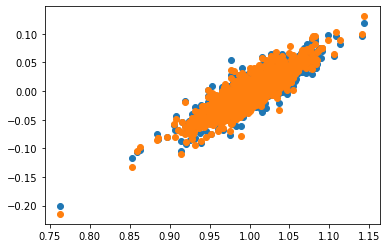

In [357]:
plt.scatter(dfx[target], fe_res.resids)
plt.scatter(dfx[target], re_res.resids)
plt.show()

In [358]:
dfx = sm.tools.tools.add_constant(dfx).fillna(0)
white_test_results = het_white(fe_res.resids, dfx[features+['const']])
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))

# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(fe_res.resids, dfx[features])
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 16.797357924277783, 'LM p-val': 0.26713764973997917, 'F-Stat': 1.2011078693427137, 'F p-val': 0.26746705037824114}
{'LM-Stat': 308.0126992808494, 'LM p-val': 1.8345085143413552e-66, 'F-Stat': 94.06597344671358, 'F p-val': 3.0166123503211763e-72}


Small p-values indicate strong heteroskedasticity!

In [359]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(re_res.resids) 
print(durbin_watson_test_results)

2.0107253581663027


In [360]:
durbin_watson_test_results = durbin_watson(fe_res.resids) 
print(durbin_watson_test_results)

2.0220849284428106


In [361]:
from linearmodels.panel import compare

print(compare({"FE": fe_res, "RE": re_res}))

                                      Model Comparison                                     
                                                             FE                          RE
-------------------------------------------------------------------------------------------
Dep. Variable                           sales_per_hcp_detrended     sales_per_hcp_detrended
Estimator                                              PanelOLS               RandomEffects
No. Observations                                           1680                        1680
Cov. Est.                                             Clustered                   Clustered
R-squared                                                0.2486                      0.2302
R-Squared (Within)                                       0.2486                      0.2464
R-Squared (Between)                                     -1.5541                     -1.1468
R-Squared (Overall)                                      0.2276                 

In [381]:
import numpy.linalg as la
from scipy import stats
import numpy as np

def hausman(fe, re):
    '''
    Ho: Random Effects Model
    '''
    b = fe.params[1:]
    B = re.params[1:]
    v_b = fe.cov.iloc[1:,1:]
    v_B = re.cov.iloc[1:,1:]
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 
 
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(fe_res, re_res) 
print('chi-Squared:' + str(hausman_results[0]))
print('degrees of freedom:' + str(hausman_results[1]))
print('p-Value:' + str(hausman_results[2]))

chi-Squared:47.082850848379884
degrees of freedom:14
p-Value:1.862748848583052e-05


If pvalue is small, then we reject the RE Model

['num_cph_visit_1_to_4m_mean', 'num_nocph_visit_1_to_4m_mean']


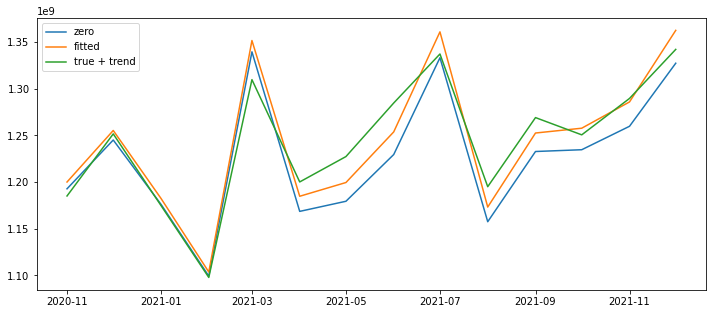

In [382]:
zero_feature = features[:2]
print(zero_feature)

df_asl3 = dfx.copy()
df_asl3['fitted_values'] = fe_res.predict(df_asl3[features_to_be_used[0]])
df_asl3[zero_feature] = df_asl3[zero_feature].apply(lambda x:x*0)
df_asl3['preds_zero'] = fe_res.predict(df_asl3[features_to_be_used[0]])

#res.fittedvalues

xx = df_asl3.groupby('yyyymm')[['preds_zero', 'fitted_values', 
                                'sales_per_hcp_trend',
                                'sales_per_hcp_season',
                                #'sales_per_hcp',
                               target]].sum(
).reset_index()

plt.figure(figsize=(12,5))
plt.plot(xx.yyyymm, xx.preds_zero*xx.sales_per_hcp_trend
         *xx.sales_per_hcp_season
        ,label='zero')
plt.plot(xx.yyyymm, xx.fitted_values*xx.sales_per_hcp_trend
         *xx.sales_per_hcp_season
         ,label='fitted')
plt.plot(xx.yyyymm, xx[target]*xx.sales_per_hcp_trend
         *xx.sales_per_hcp_season
         ,label='true + trend')
plt.legend()

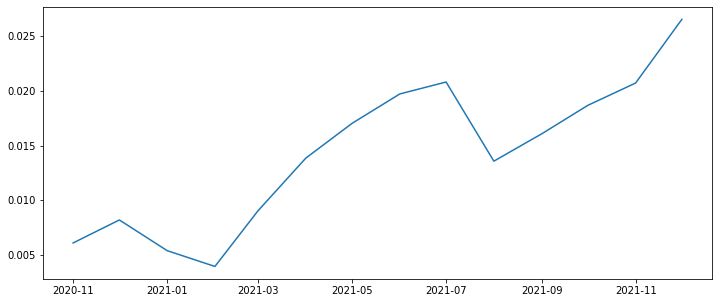

In [379]:
plt.figure(figsize=(12,5))
plt.plot(xx.yyyymm, ((xx.fitted_values*xx.sales_per_hcp_trend*xx.sales_per_hcp_season)/
                     (xx.preds_zero*xx.sales_per_hcp_trend*xx.sales_per_hcp_season)-1))

In [380]:
original = xx.fitted_values*xx.sales_per_hcp_trend*xx.sales_per_hcp_season
zero = xx.preds_zero*xx.sales_per_hcp_trend*xx.sales_per_hcp_season

print(np.sum(original)/np.sum(zero)-1)

0.01446646980589783
